# Boundary integral equations: formulations and conditioning

This notebook provides some supporting material for the second lecture of AMS313 on boundary integral equation methods. The goal is to explore the choice of boundary integral formulation, and how this choice affects:
- The accuracy of the solution
- The conditioning of the linear system
- The cost of the *assembly* stage

We will spend most of our time solving a Dirichelet problem, but at the end I will show how BIEs can be used in more complex setups such as transmission problems!

![transmission](./transmission.png)

<div class="alert alert-warning"> 
<b>Preamble: </b>
Run the cell below to activate the project's environment, download the required packages, and bring some modules and functions into scope.

In [2]:
using Pkg
Pkg.activate()
Pkg.instantiate()
Pkg.status()

using Plots, WaveProp, IterativeSolvers, LinearAlgebra, Printf
using WaveProp.PhysicalProblem
using WaveProp.Nystrom
using WaveProp.Nystrom: single_doublelayer_dim, adjointdoublelayer_hypersingular_dim

 Activating environment at `~/Projects/AMS313/notebooks/Project.toml`


Status `~/Projects/AMS313/notebooks/Project.toml`
  [6e4b80f9] BenchmarkTools v0.6.0
  [42fd0dbc] IterativeSolvers v0.9.0
  [91a5bcdd] Plots v1.10.6
  [1fd47b50] QuadGK v2.4.1
  [fdea26ae] SIMD v3.2.1
  [59f5f407] WaveProp v0.1.0 `https://github.com/WaveProp/WaveProp.git#main`
  [37e2e46d] LinearAlgebra
  [de0858da] Printf


<a id='problem-formulation'></a>
## Problem formulation

We will consider an exterior Dirichlet problem in the context of the Helmholtz equation. That is, we seek a function $u$ such that:
\begin{align}
\Delta u + k^2u &= 0, &x \in \mathbb{R}\setminus \overline{\Omega} \quad \mbox{(PDE)}\\
u &= f, &x \in \Gamma \quad \mbox{(BC)}
\end{align}
In the context of acoustic scattering, this typically corresponds to sound-soft scattering problems. The obstacle is $\Omega$, and its boundary is denoted by $\Gamma$. 

As seen in the lecture, there are several possible **boundary integral representations** of $u$, and depending on the choice made a different **boundary integral equation** is obtained. In what follows we consider the following formulations:

\begin{align}
S[\sigma] &= f \quad &\mbox{(single-layer)}\\
\left(\frac{I}{2} + D\right)[\sigma] &= f \quad &\mbox{(double-layer)}\\
\left(\frac{I}{2} + D- ikS \right)[\sigma] &= f \quad &\mbox{(combined field)}\\
S[\sigma] &= \left(-\frac{I}{2} + D\right)[f] \quad &\mbox{(direct I)}\\
\left(\frac{I}{2} + D' \right)[\sigma] &= T[f] \quad &\mbox{(direct II)}
\end{align}

Once $\sigma$ is found, the solution $u$ can be reconstructed using:

\begin{align}
u &= \mathcal{S}[\sigma] \quad &\mbox{(single-layer)}\\
u &= \mathcal{D}[\sigma]\quad &\mbox{(double-layer)}\\
u &= \mathcal{D}[\sigma] - ik\mathcal{S}[\sigma] \quad &\mbox{(combined field)}\\
u &= \mathcal{D}[f]- \mathcal{S}[\sigma] \quad &\mbox{(direct I or II)}
\end{align}

In what follows we will numerically solve this scattering problem using all of the aforementioned formulations, and compare them!

## Setting up the code

To make our study a bit simpler, we will lump all the formulations into a single function which I will call `solve`. This function takes a mesh `Γ`, and right hand side `f`, and a wavenumber `k`, and returns a dictionary with keys representing the formulation, and values given by `(u,hist,L)`, where `u` is the continuous approximation of the solution, `hist` is a structure storing `gmres` convergence information, and `L` is the linear operator. None of this is efficient, but that is not our focus here. Below is the solve function:

In [3]:
formulations = ("single-layer","double-layer","combined field", "direct 1", "direct 2")

function solve(Γ,f,k;formulations=formulations)
    pde = Helmholtz(dim=2;k)
    # create the potentials
    𝒮 = SingleLayerPotential(pde,Γ)
    𝒟 = DoubleLayerPotential(pde,Γ)
    # and the operators
    S,D  = single_doublelayer_dim(pde,Γ)
    D′,T = adjointdoublelayer_hypersingular_dim(pde,Γ)
    # a dictionary to store the solutions as well as convergence info
    output = Dict()
    # single-layer formulation
    if "single-layer" in formulations
        L   = S
        rhs = f
        σ, history = gmres(L,rhs,log=true,restart=1000)
        u   = let σ=σ
            x-> 𝒮[σ](x)
        end
        output["single-layer"] = (u,history,L)
    end
    # double-layer formulation
    if "double-layer" in formulations
        L   = I/2 + D
        rhs = f
        σ, history = gmres(L,rhs,log=true,restart=1000)
        u = let σ=σ 
            x-> 𝒟[σ](x)
        end
        output["double-layer"] = (u,history,L)
    end
    # combined field formulation
    if "combined field" in formulations
        k   = pde.k
        L   = I/2 + D - im*k*S
        rhs = f
        σ, history = gmres(L,rhs,log=true,restart=1000)
        u = let σ=σ 
            x -> 𝒟[σ](x) - im*k*𝒮[σ](x)
        end
        output["combined field"] = (u,history,L)
    end
    # direct formulation I
    if "direct 1" in formulations
        L = S
        rhs = -f/2 + D*f
        σ, history = gmres(L,rhs,log=true,restart=1000)
        u = let σ = σ
            x-> 𝒟[f](x) - 𝒮[σ](x)
        end
        output["direct 1"] = (u,history,L)
    end
    # direct formulation II
    if "direct 2" in formulations
        L = I/2 + D′
        rhs = T*f
        σ, history = gmres(L,rhs,log=true,restart=1000)
        u = let σ = σ
            x-> 𝒟[f](x) - 𝒮[σ](x)
        end
        output["direct 2"] = (u,history,L)
    end
    return output
end

solve (generic function with 1 method)

In order to use it, we will need to construct a curve $\Gamma$ enclosing a domain $\Omega$. This is the purpose of the next block, which defines a convenience function for constructing a kite-shaped obstacle with $n$ elements, and a $3$-point Gauss-Legendre quadrature on each element. 

In [4]:
function kite_mesh(n)
    kite   = WaveProp.Geometry.Kite()
    Ω      = WaveProp.Geometry.Domain(kite)
    M      = WaveProp.Mesh.meshgen(Ω;n)
    Γ      = WaveProp.Geometry.boundary(Ω)
    Γ_mesh = WaveProp.Nystrom.NystromMesh(view(M,Γ),order=5)
    return Γ_mesh
end

kite_mesh (generic function with 1 method)

<a id='validation'></a>
## Validating against an exact solution

Before taking things further, let us validate (at least partially) our code by checking our numerical results against an exact solution. To build the exact solution, we will take a point source located inside our obstacle. More precisely, letting $x_s = (0,0.1)$, we will consider the function $u_e(x) = G(x_s,x)$, where $G$ is the Greens function for Helmholtz. By construction this is a solution of Helmholtz equation. We will then give to our solver the Dirichlet trace $\gamma_0 u_e$, and verify that our representation recovers the exact solution at some test point $x_0$ outside of $\Omega$, which we take to be $x_0 = (5,5)$. A more complex exact solution and/or testing procedure can be devised, but this one suffices for what we want to show. Here is the exact solution and its trace on the boundary:

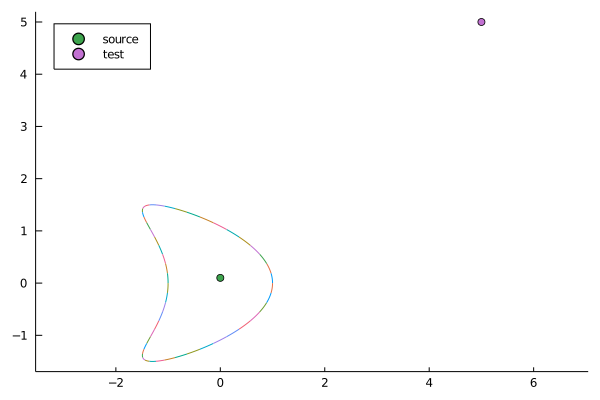

In [5]:
k = 10
pde = Helmholtz(dim=2;k)
xₛ = (0,0.1)
x₀ = (5,5)
G  = SingleLayerKernel(pde)
uₑ = x -> G(xₛ,x)
plot(kite_mesh(50))
scatter!([xₛ],label="source")
scatter!([x₀],label="test",legend=:topleft)

We can now solve our problem and check the error, the condition number, and the number of iterations for of GMRES:

In [6]:
Γ    = kite_mesh(50)
f    = γ₀(uₑ,Γ)
data = solve(Γ,f,k);

# convenience function
rel_error(e::Number,a::Number) = abs((e - a)/e)

# print the results
function display_data(data,k)
    ppw = length(Γ)/(sum(Γ.qweights)/(2π) * k ) #points per wavelength
    @printf "\n Computations using %.2f points per wavelength \n\n" ppw
    println("-"^90)    
    @printf "%20s %20s %20s %20s \n" "formulation" "error" "condition" "iterations"
    println("-"^90)
    for key in keys(data)
        u,hist,L = data[key]
        er = rel_error(uₑ(x₀),u(x₀))
        κ  = cond(L)
        it = hist.iters
        @printf "%20s %20e %20f %20i \n" key er κ it
    end

end
display_data(data,k)


 Computations using 10.11 points per wavelength 

------------------------------------------------------------------------------------------
         formulation                error            condition           iterations 
------------------------------------------------------------------------------------------
            direct 1         9.740497e-05           167.907860                   60 
        single-layer         5.457719e-04           167.907860                   60 
            direct 2         8.721995e-03            60.839022                   38 
        double-layer         7.309180e-04            59.983181                   38 
      combined field         8.826994e-05             6.905727                   20 


<div class="alert alert-warning"> 
<b>Question: </b>
We clearly see an important difference in all three categories. Can you speculate on the reason(s)?

What happens if we refine?

In [7]:
Γ    = kite_mesh(100)
f    = γ₀(uₑ,Γ)
data = solve(Γ,f,k);
display_data(data,k)
Γ    = kite_mesh(200)
f    = γ₀(uₑ,Γ)
data = solve(Γ,f,k);
display_data(data,k)


 Computations using 20.22 points per wavelength 

------------------------------------------------------------------------------------------
         formulation                error            condition           iterations 
------------------------------------------------------------------------------------------
            direct 1         1.397779e-06           166.283149                   56 
        single-layer         1.828058e-06           166.283149                   56 
            direct 2         1.560934e-03            60.940668                   38 
        double-layer         1.905963e-06            59.737524                   38 
      combined field         1.410829e-06             5.276954                   20 

 Computations using 40.43 points per wavelength 

------------------------------------------------------------------------------------------
         formulation                error            condition           iterations 
------------------------------

<div class="alert alert-warning"> 
<b>Question: </b>
Why is the conditioning of the single-layer formulation getting worse? Is this affecting the number of iterations?

Note that the error decreases as we increase $n$, and that it does so faster than e.g. linear convergence. The precise order will depend on the formulation and the integral operators involved, and are related to the singular integration scheme (which we did not cover).

## Investigating the spectrum

The difference in the number of GMRES iterations can be understood (at least partially) if we look at the eigenvalues of the linear system. As discussed in class, $S,D,D'$ are compact operators and therefore we know that their spectrum can only accumulate at $0$. So do we see the expected accumulation points in practice? Here is what the spectrum looks like:


 Computations using 40.43 points per wavelength 

------------------------------------------------------------------------------------------
         formulation                error            condition           iterations 
------------------------------------------------------------------------------------------
            direct 1         3.679729e-08           285.450054                   56 
        single-layer         4.377331e-08           285.450054                   56 
            direct 2         2.074374e-04            60.920824                   38 
        double-layer         4.987614e-08            59.737579                   38 
      combined field         3.226663e-08             5.310899                   20 


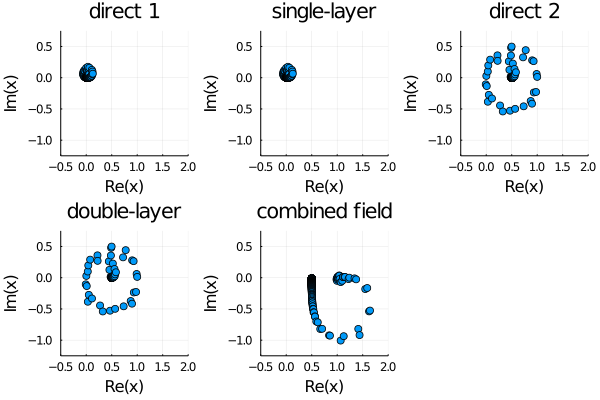

In [8]:
Γ    = kite_mesh(200)
f    = γ₀(uₑ,Γ)
data = solve(Γ,f,k);

function plot_spectrum(data)
    figs = []
    for key in keys(data)
        u,hist,L = data[key]
        λ = eigvals(L)
        fig = scatter(λ,label="",title=key,xlims=(-0.5,2),ylims=(-1.25,0.75))
        push!(figs,fig)
    end
    plot(figs...)
end

display_data(data,k)
plot_spectrum(data)

The results are similar to what we expected from the theory. For the first-kind integral equations, we see an accumulation of the spectrum around $0$. The second-kind formulation clusters the points around $0.5$ -- a consequence of the fact that we had $I/2 + \mbox{compact}$. Furthermore, the combined field formulation appears to shift the eigenvalues away from $0$. The CFIE should become better as we increase the frequence $k$, so let us check how the pictures change:


 Computations using 10.11 points per wavelength 

------------------------------------------------------------------------------------------
         formulation                error            condition           iterations 
------------------------------------------------------------------------------------------
            direct 1         9.232917e-05           930.007491                  166 
        single-layer         1.137003e-03           930.007491                  168 
            direct 2         2.463199e-03            92.817423                  127 
        double-layer         2.881589e-05            96.350670                  128 
      combined field         9.140470e-05             8.347527                   26 


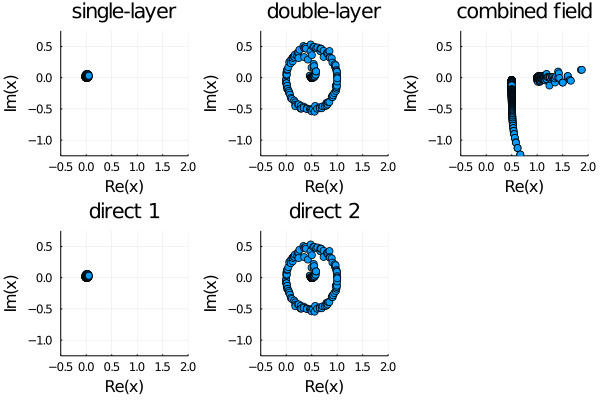

In [9]:
k    = 40
pde  = Helmholtz(dim=2;k)
G    = SingleLayerKernel(pde)
uₑ   = x -> G(xₛ,x)
Γ    = kite_mesh(200)
f    = γ₀(uₑ,Γ)
data = solve(Γ,f,k)

function plot_spectrum(data)
    figs = []
    for key in ("single-layer","double-layer","combined field", "direct 1", "direct 2")
        u,hist,L = data[key]
        λ = eigvals(L)
        fig = scatter(λ,label="",title=key,xlims=(-0.5,2),ylims=(-1.25,0.75))
        push!(figs,fig)
    end
    plot(figs...)
end

display_data(data,k)
plot_spectrum(data)

We observe a relatively large increase in the number of iterations for all the formulations except for the combined-field, which went from $20$ to $26$ when the frequency was multiplied by 4!

## Invertibility of linear system

As briefly discussed in class, some formulations are not solvable for all wavenumbers $k$. In particular we saw that formulations such as $S[\sigma] = f$ can fail to be uniquely solvable due to the presence of a non-trivial null-space associated with an interior Laplace eigenvalue problem. Since finding the resonant frequencies (i.e. finding the eigenvalues) is a difficult problem, we will simply content ourselves with a practical investigation of the possible issues. 

For this purpose, I will fix the curve $\Gamma$, and plot the condition number of the various formulations for various values of $k$. Or hope is that for formulations which are not always uniquely solvable, we should see peaks on the condition number at certain $k_n$.

In [10]:
# chose the range of k
Γ    = kite_mesh(200)
kk   = 2π:0.025:3π
cond_SL   = similar(kk)
cond_CFIE = similar(kk)
iters_SL  = similar(kk)
iters_CFIE = similar(kk);

In [11]:
Threads.@threads for n in 1:length(kk)
    k    = kk[n]
    pde  = Helmholtz(dim=2;k)
    G    = SingleLayerKernel(pde)
    uₑ   = x -> G(xₛ,x)
    f    = γ₀(uₑ,Γ)
    data = solve(Γ,f,k,formulations=["single-layer","combined field"])
    _,hist,L = data["single-layer"]
    cond_SL[n] = cond(L)
    iters_SL[n] = hist.iters
    _,hist,L  = data["combined field"]
    cond_CFIE[n] = cond(L)
    iters_CFIE[n] = hist.iters
end

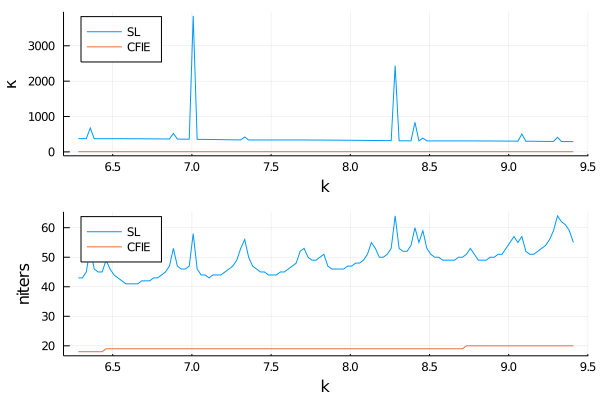

In [12]:
fig_cond = plot(kk,cond_SL,label="SL",xlabel="k",ylabel="κ",legend=:topleft)
plot!(fig_cond,kk,cond_CFIE,label="CFIE")
fig_iters = plot(kk,iters_SL,label="SL",xlabel="k",ylabel="niters",legend=:topleft)
plot!(fig_iters,kk,iters_CFIE,label="CFIE")
plot(fig_cond,fig_iters,layout=(2,1))

The observation is that indeed the conditioning of the single-layer formulation showcases some discrete peaks at what are probably resonant frequencies of the interior eigenvalue problem. 

## Caderón preconditioners

An alternative to choosing a different formulation is to instead **precondition** our linear system. These can be done in a variety of ways, which include e.g. algebraic preconditioners such a coarse $\mathcal{H}-\mathrm{LU}$ factorization, or analytic preconditioners such as the Calderón preconditioners. In this section we will briefly explore the use of a Calderon preconditioner. 

Calderón preconditioners are based on the following identities:
\begin{align*}
DS &= SD',\\
TD &= D'N, \\
D^2 - ST &= \frac{I}{4},\\
(D')^2-TS &= \frac{I}{4}
\end{align*}

To illustrate how these can be used to reformulate our problem, consider a single-layer formulation where we seek to solve:
\begin{align*}
S[\sigma] = f
\end{align*}
Multiplying (on the left) by the hypersingular operator $T$ we obtain
\begin{align*}
TS[\sigma] = T[f].
\end{align*}
Now using the fourth identity yields
\begin{align*}
\left( -\frac{I}{4} + (D')^2 \right)[\sigma] = T[f].
\end{align*}
which is an integral equation of the second kind. This is expected to improve the conditioning of the system, as can be seen in the numerical example below:

In [13]:
pde = Helmholtz(dim=2,k=20)
Γ   = kite_mesh(200)
S, D = single_doublelayer_dim(pde,Γ)
Da, H = adjointdoublelayer_hypersingular_dim(pde,Γ)
L   = -I/4 + Da*Da
println("Condition of S :           $(cond(S))")
println("Condition of -I/4 + D'D' : $(cond(L))")

Condition of S :           1222.0499899106317
Condition of -I/4 + D'D' : 441.9820599535139


We clearly see some improvement on the condition number, but keep in there is a also the cost associated to the computation of the new operators...

## Some pretty pictures...

If we got this far, I think we deserve some pretty pictures. So far we have looked at errors, and iterations, and spectrum, and lots and lots of formulations for the same toy-problem... but there was no scattering! So let us finally solve some scattering problem. 

### Sound-soft scattering

We consider a incident plane-wave of the form $u_i = exp(ik \vec{d} \cdot x)$ where $\vec{d}$ is a unit vector giving the direction of the incident wave. To use a BIE for an exterior problem, we actually need the field to satisfy some conditions at infinity known as the Sommerfeld radiation condition. This was automatically the case in our example in the [validation section](#validation) since the field we were solving for was given by a Greens function! For scattering problems, we need to split the total field as follows:
\begin{align}
    u_t = u_i + u
\end{align}
where $u_t$ is the total field, and $u$ is the scattered field that we solve for. 

Assuming for simplicity a sound-soft obstacle (so that we don't have to re-derive the formulations again), the boundary condition for $u$ is 
\begin{align}
    u = -u_i \quad \mbox{on} \quad \Gamma
\end{align}

Let us set this up and plot the scattered field:

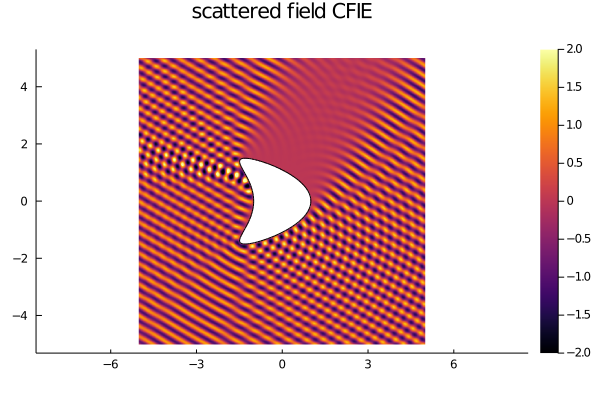

In [14]:
k    = 20
θ    = π/3
d    = (cos(θ),sin(θ))
uᵢ   = x -> exp(im*k*dot(d,x))
Γ    = kite_mesh(100)
f    = -γ₀(uᵢ,Γ)
data = solve(Γ,f,k;formulations=["combined field"])

u,hist,L = data["combined field"]

h = 2π/k/10 # 10 pts per wavelength for plotting
x = y = -5:h:5
U = [isinside((x,y),Γ) ? NaN + NaN*im : u((x,y)) + uᵢ((x,y)) for y in y, x in x]
fig = heatmap(x,y,real(U),clims=(-2,2),title="scattered field CFIE")
plot!(fig,Γ,lc=:black)

It is always fun to see multiple scattering...

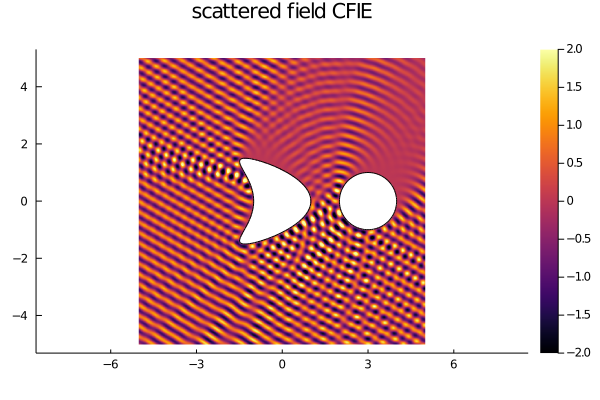

In [15]:
kite   = WaveProp.Geometry.Kite()
circ   = WaveProp.Geometry.Circle(center=(3,0))
Ω      = WaveProp.Geometry.Domain([kite,circ])
M      = WaveProp.Mesh.meshgen(Ω;n=100)
Γ_geo  = WaveProp.Geometry.boundary(Ω)
Γ      = WaveProp.Nystrom.NystromMesh(view(M,Γ_geo),order=5)
f      = -γ₀(uᵢ,Γ)

data = solve(Γ,f,k;formulations=["combined field"])

u,hist,L = data["combined field"]

h = 2π/k/10 # 10 pts per wavelength for plotting
x = y = -5:h:5
U = [isinside((x,y),Γ) ? NaN + NaN*im : u((x,y)) + uᵢ((x,y)) for y in y, x in x]
fig = heatmap(x,y,real(U),clims=(-2,2),title="scattered field CFIE")
plot!(fig,Γ,lc=:black)

### Transmission problem

A more involved application is that of a transmission problem, where instead of imposing a boundary condition on $\Gamma$ and solving for the field on $\mathbb{R}^2 \setminus \bar \Omega$, we seek instead a field $u$ solution of
\begin{aligned}
    \Delta u + k_1^2 u &= 0 \quad \text{on} \quad \Omega_1 = \Omega,\\
    \Delta u + k_2^2 u &= 0 \quad \text{on} \quad \Omega_2 = \mathbb{R}^2 \setminus \bar{\Omega}, 
\end{aligned}

and whose Dirichlet and Neumann traces are continuous across the interface $\Gamma$.

We use an indirect formulation, where each individual field is represented as
$$
u(x) = (\mathcal D_j\varphi)(x)-(\mathcal S_j\psi)(x) \quad \text{for} \quad x \in \Omega_j,
$$
using two density functions $\varphi,\psi:\Gamma\to\mathbb C$,
where $\mathcal{D}_j$ and $\mathcal{S}_j$ are the integral potentials with wavenumber $k=k_j$.

Imposing continuity of Dirichlet traces yields the following equation:
$$
    \gamma_0^+ u_2 = \left( \frac{I}{2} + D_2 \right) \varphi - S_2 \psi + u_i = \gamma_0^- u_1 = \left( -\frac{I}{2} + D_1 \right) \varphi - S_1 \psi
$$
Similarly, imposing continuity of the Neumann trace yields:
$$
    \gamma_1^+ u_2 = H_2 \varphi - \left( -\frac{I}{2} + K_2 \right) \psi + \gamma_1^+ u_i = \gamma_1^- u_1 = H_1 \varphi - \left( -\frac{I}{2} + K_1 \right) \psi
$$

After a bit of rearranging, we can obtain the following linear (square) system of equations for the auxiliary densities $\varphi$ and $\psi$:

$$
\begin{bmatrix}
    I + (D_2 - D_1) & -(S_2-S_1) \\
    (H_2-H_1) & I - (K_2-K_1)
\end{bmatrix}
\begin{bmatrix}
    \varphi \\
    \psi
\end{bmatrix}
= -
\begin{bmatrix}
    \gamma_0^+u_i \\
    \gamma_1^+u_i
\end{bmatrix}
$$

The following lines of code will assemble and solve, in a somewhat inneficient way, this system:

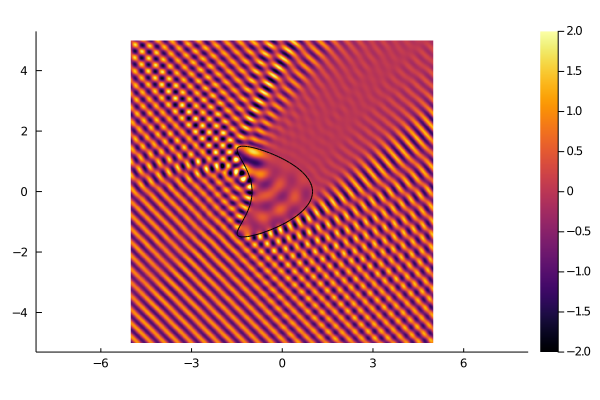

In [16]:
Γ    = kite_mesh(100)
k1    = 10; pde1  = Helmholtz(;dim=2,k=k1)
k2    = 20; pde2  = Helmholtz(;dim=2,k=k2)
θ  = π/4
d  = (cos(θ),sin(θ))
uᵢ  = (x) ->   exp(im*k2*dot(d,x))
∂uᵢ = (x,ν) -> im*k2*dot(d,ν)*uᵢ(x)
rhs = vcat(-γ₀(uᵢ,Γ),-γ₁(∂uᵢ,Γ) )

## assemble linear operators
S1,D1 = single_doublelayer_dim(pde1,Γ)
S2,D2 = single_doublelayer_dim(pde2,Γ)
K1,H1 = adjointdoublelayer_hypersingular_dim(pde1,Γ)
K2,H2 = adjointdoublelayer_hypersingular_dim(pde2,Γ)

## put together the global system
L = [I+(D2-D1) -(S2-S1);
     H2-H1       I-(K2-K1)]

## solve it
sol = L\rhs
N   = length(sol)
φ   = sol[1:div(N,2)]
ψ   = sol[div(N,2)+1:end]

## and plot it
u1 = x -> DoubleLayerPotential(pde1,Γ)[φ](x) - SingleLayerPotential(pde1,Γ)[ψ](x)
u2 = x -> DoubleLayerPotential(pde2,Γ)[φ](x) - SingleLayerPotential(pde2,Γ)[ψ](x) + uᵢ(x)

h = 2π/max(k1,k2)/20 # 10 pts per wavelength
x = y = -5:h:5
U = [isinside((x,y),Γ) ? u1((x,y)) : u2((x,y)) for y in y, x in x]
fig = heatmap(x,y,real(U),clims=(-2,2))
plot!(fig,Γ,lc=:black)

## Concluding remarks

In this notebook we scratched the surface of the *formulation* problem in BIE methods. We considered a simple Dirichlet problem, and solved it using 5 different formulations. The 